In [3]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#Batch Size
batch_size = 128
image_size = 64
workers = 2

numchannels = 3 #Number of channels
latent = 100 #Latent Space Size
gen_feat = 64 # Size of feature maps in generator
dis_feat = 64 # Size of feature maps in discriminator

# Number of gpus available. Use 0 for cpu.
num_gpu = 1

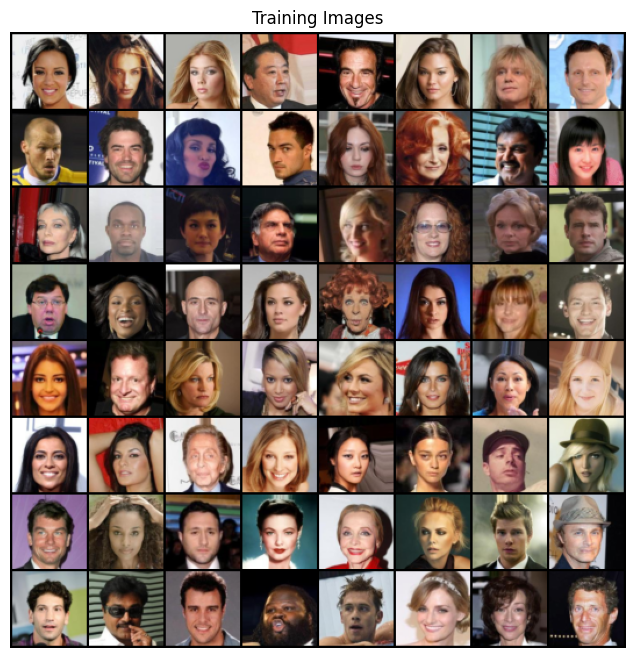

In [5]:
#Impliment data transforms and loading

#TODO
dataroot = r'/content/24789_hw2/img_align_celeba2'
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = dset.ImageFolder(root=dataroot, transform=transform)

# Create the dataloader
#TODO
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

#Select device
device = torch.device("cuda:0" if (torch.cuda.is_available() and num_gpu > 0) else "cpu")

#Display real images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
#Weight initialization for Generator and Discriminator no changes required
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, num_gpu):
        super(Generator, self).__init__()
        self.num_gpu = num_gpu
        self.main = nn.Sequential(
            #Create Generator using ConvTranspose2d
            #TODO
            nn.ConvTranspose2d( latent, gen_feat * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gen_feat * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(gen_feat * 8, gen_feat * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d( gen_feat * 4, gen_feat * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d( gen_feat * 2, gen_feat, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d( gen_feat, numchannels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the generator
netG = Generator(num_gpu).to(device)

#Device selection
if (device.type == 'cuda') and (num_gpu > 1):
    netG = nn.DataParallel(netG, list(range(num_gpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTrans

In [9]:
class Discriminator(nn.Module):
    def __init__(self, num_gpu):
        super(Discriminator, self).__init__()
        self.num_gpu = num_gpu
        self.main = nn.Sequential(
            #Create Discriminator using Conv2d
            #TODO
            nn.Conv2d(numchannels, dis_feat, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_feat, dis_feat * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feat * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_feat * 2, dis_feat * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feat * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_feat * 4, dis_feat * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feat * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_feat * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the Discriminator
netD = Discriminator(num_gpu).to(device)

#Device Selection
if (device.type == 'cuda') and (num_gpu > 1):
    netD = nn.DataParallel(netD, list(range(num_gpu)))

netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
#Select Loss Function
#TODO
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, latent, 1, 1, device=device)

#Real and fake labels for training
real_label = 1.
fake_label = 0.

lr = 0.0003
beta1 = 0.5

# Setup optimizers for Generator and Discriminator
#TODO
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [13]:
# Training Parameters
num_epochs = 50
lr = 0.0002
beta1 = 0.5

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ## Train with all-real batch

        #Train Discriminator
        #TODO
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_cpu).view(-1)

        errD_real = criterion(output, label)

        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, latent, 1, 1, device=device)

        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)

        errD_fake = criterion(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake

        optimizerD.step()


        netG.zero_grad()
        label.fill_(real_label)

        output = netD(fake).view(-1)

        errG = criterion(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        #Record Losses to Plot
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/389]	Loss_D: 0.1512	Loss_G: 7.3393	D(x): 0.9253	D(G(z)): 0.0045 / 0.0035
[0/50][50/389]	Loss_D: 0.8860	Loss_G: 3.8712	D(x): 0.7484	D(G(z)): 0.3242 / 0.0378
[0/50][100/389]	Loss_D: 1.1883	Loss_G: 1.6173	D(x): 0.4709	D(G(z)): 0.1796 / 0.2608
[0/50][150/389]	Loss_D: 0.8789	Loss_G: 1.8581	D(x): 0.5659	D(G(z)): 0.1334 / 0.1994
[0/50][200/389]	Loss_D: 1.4168	Loss_G: 5.0759	D(x): 0.9422	D(G(z)): 0.6774 / 0.0177
[0/50][250/389]	Loss_D: 1.0925	Loss_G: 2.7911	D(x): 0.4389	D(G(z)): 0.0276 / 0.1095
[0/50][300/389]	Loss_D: 0.5724	Loss_G: 2.9759	D(x): 0.8314	D(G(z)): 0.2844 / 0.0754
[0/50][350/389]	Loss_D: 0.9429	Loss_G: 4.6336	D(x): 0.7798	D(G(z)): 0.3957 / 0.0240
[1/50][0/389]	Loss_D: 0.7909	Loss_G: 3.8614	D(x): 0.7062	D(G(z)): 0.2520 / 0.0355
[1/50][50/389]	Loss_D: 1.0815	Loss_G: 3.9152	D(x): 0.7786	D(G(z)): 0.4918 / 0.0381
[1/50][100/389]	Loss_D: 0.8129	Loss_G: 2.6275	D(x): 0.6087	D(G(z)): 0.1420 / 0.1196
[1/50][150/389]	Loss_D: 0.9110	Loss_G: 2.3884	D(x): 0.62

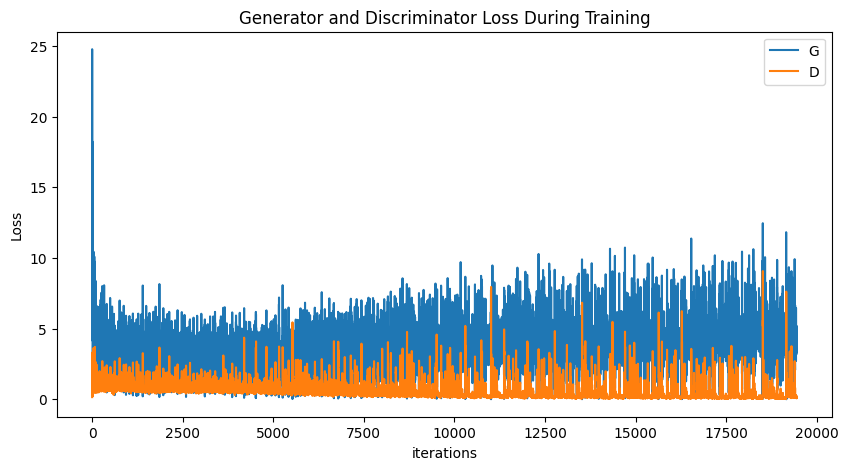

In [14]:
#Plot Your Generator and Discriminator Loss
#No Changes Needed
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

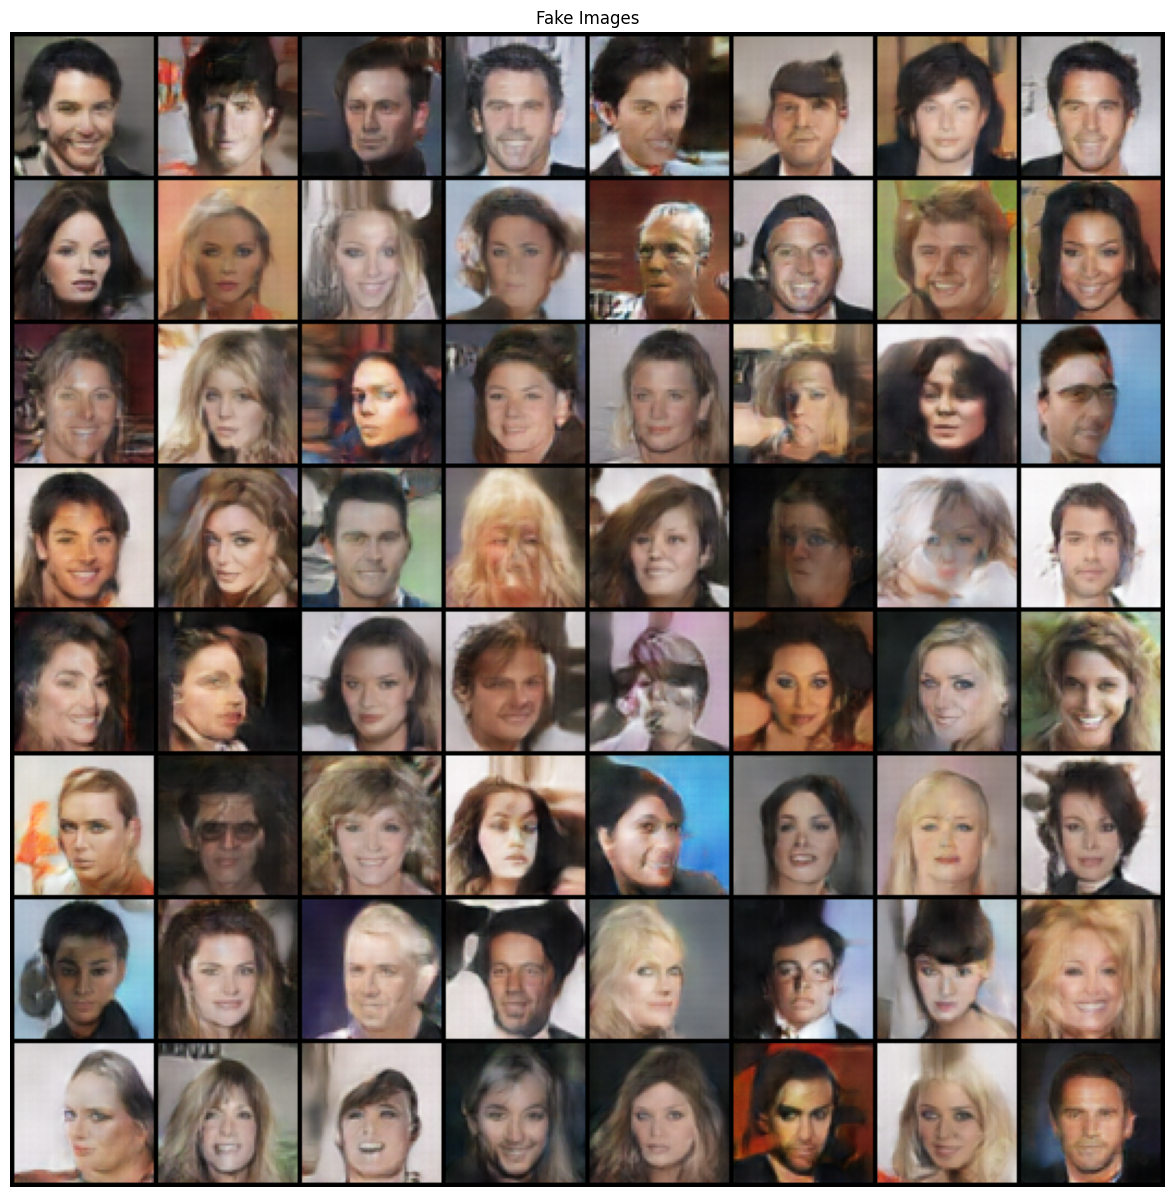

In [15]:
# Fake Images Grid
#No Changes Needed
plt.figure(figsize=(15,15))
plt.subplot(1,1,1)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()